In [1]:
import torch
import torchvision.models as models
import zipfile
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# UNZIP THE DATASET
zip_path = "/content/drive/MyDrive/CMI/Sem 4/AML/data.zip"  # Update this path
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Data extracted successfully!")

Data extracted successfully!


In [4]:
# DEFINE DATA TRANSFORMATIONS
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## LOAD AND SPLIT DATASET

In [5]:
dataset = datasets.ImageFolder(root="/content/data/data", transform=transform)

# Print class mappings (Chicken → 0, Duck → 1)
print(f"Class Mapping: {dataset.class_to_idx}")

# Train-Validation-Test Split (70% Train, 15% Validation, 15% Test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_data)}")

Class Mapping: {'chicken-images': 0, 'duck-images': 1}
Training samples: 1077, Validation samples: 230, Test samples: 232


## LOAD PRETRAINED RESNET-50

In [6]:
model = models.resnet50(pretrained=True)

# Replace the last fully connected layer for 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Chicken and Duck

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.6MB/s]


In [7]:
# DEFINE LOSS FUNCTION & OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

## Evaluate Pre-trained Model on Test Set (Before Fine-Tuning)

In [8]:
def evaluate_model(loader, model, title="Model Evaluation"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=title):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification Report
    class_names = ["Chicken", "Duck"]
    print(f"\nClassification Report - {title}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

Before Fine-Tuning: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]



Classification Report - Before Fine-Tuning:
              precision    recall  f1-score   support

     Chicken       0.31      0.33      0.32        75
        Duck       0.67      0.64      0.66       157

    accuracy                           0.54       232
   macro avg       0.49      0.49      0.49       232
weighted avg       0.55      0.54      0.55       232



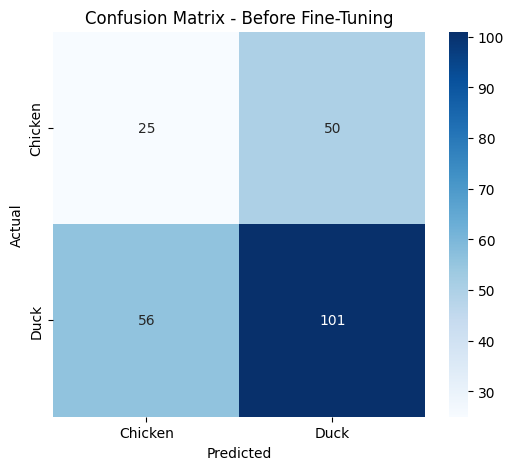

In [9]:
# Evaluate model before fine-tuning
evaluate_model(test_loader, model, title="Before Fine-Tuning")

## Training the Model

In [10]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update tqdm progress bar
        progress_bar.set_postfix(loss=running_loss / (total // train_loader.batch_size))

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%")

print("Training complete!")

Epoch 1/5: 100%|██████████| 34/34 [00:14<00:00,  2.33it/s, loss=0.629]


Epoch [1/5], Loss: 0.6107, Train Accuracy: 67.32%


Epoch 2/5: 100%|██████████| 34/34 [00:13<00:00,  2.50it/s, loss=0.508]


Epoch [2/5], Loss: 0.4927, Train Accuracy: 78.09%


Epoch 3/5: 100%|██████████| 34/34 [00:13<00:00,  2.56it/s, loss=0.418]


Epoch [3/5], Loss: 0.4057, Train Accuracy: 84.77%


Epoch 4/5: 100%|██████████| 34/34 [00:13<00:00,  2.54it/s, loss=0.358]


Epoch [4/5], Loss: 0.3479, Train Accuracy: 90.25%


Epoch 5/5: 100%|██████████| 34/34 [00:13<00:00,  2.50it/s, loss=0.309]

Epoch [5/5], Loss: 0.3003, Train Accuracy: 93.04%
Training complete!


## Evaluate Fine-Tuned Model

After Fine-Tuning: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]



Classification Report - After Fine-Tuning:
              precision    recall  f1-score   support

     Chicken       1.00      0.73      0.85        75
        Duck       0.89      1.00      0.94       157

    accuracy                           0.91       232
   macro avg       0.94      0.87      0.89       232
weighted avg       0.92      0.91      0.91       232



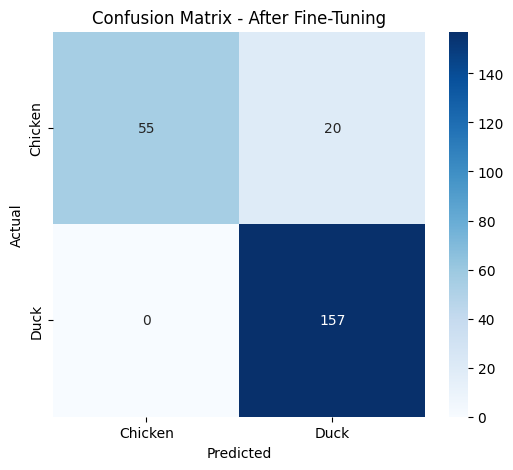

In [11]:
evaluate_model(test_loader, model, title="After Fine-Tuning")